In [1]:
import math

import numpy as np
import matplotlib.pyplot as plt

import requests

import osmnx as ox
import folium

from geopy.geocoders import Nominatim

In [2]:
address_file_path = './data/addresses.csv'

In [3]:
def get_employee_data(file_path):
    '''
    output = list of employee data
    each element of the list is a list [first_name, last_name, address]
    '''
    with open(file_path,'r') as f:
        employee_info = f.readlines()
    employee_info = [emp[:-1] for emp in employee_info[1:]]
    employee_info = [emp.split(';') for emp in employee_info]
    return employee_info

In [5]:
employee_data = get_employee_data(address_file_path)
employee_addresses = [emp[2] for emp in employee_data]

In [6]:
geolocator = Nominatim(user_agent="covoiturage")

In [15]:
target_address = '9 Boulevard Decouz, 74000 Annecy France'
target_location = geolocator.geocode(target_address)

In [8]:
employee_locations = [geolocator.geocode(el) for el in employee_addresses]

In [16]:
full_map = folium.Map(location=[target_location.latitude, target_location.longitude], zoom_start=11)
folium.Marker([target_location.latitude, target_location.longitude]).add_to(full_map)
for cur_loc in employee_locations:
    folium.Circle(radius = 10, location=[cur_loc.latitude, cur_loc.longitude], color='red', fill=True).add_to(full_map)
full_map

In [17]:
def get_route_distance(locationA, locationB):
    '''
    uses OSRM API to calculate 'car' distance between two points
    result returned in km
    '''
    api_base_str = 'http://router.project-osrm.org/route/v1/driving/' 
    getStr = '{}/{},{};{},{}?overview=false'.format(api_base_str, locationA.longitude, locationA.latitude, locationB.longitude, locationB.latitude)
    optRoute = requests.get(getStr)
    return optRoute.json()['routes'][0]['distance'] / 1000.0

In [18]:
def get_employees_distance_matrix(employee_locs):
    '''
    returns distance matrix of employees
    '''
    num_emp = len(employee_locs)
    dist = np.ndarray((num_emp,num_emp))
    for i in range(num_emp):
        loc_i = employee_locations[i]
        dist[i,i] = 0
        for j in range(i+1, num_emp):
            loc_j = employee_locations[j]
            dist[i,j] = get_route_distance(loc_i, loc_j)
            dist[j,i] = dist[i,j]
    return dist

In [19]:
def get_employees_distance_to_target(employee_locs, target_loc):
    '''
    returns distance vector of each employee to target_location
    '''
    num_emp = len(employee_locs)
    dist = np.empty(num_emp)
    for i in range(num_emp):
        loc_i = employee_locations[i]
        dist[i] = get_route_distance(loc_i, target_loc)
    return dist

In [20]:
dist_matrix = get_employees_distance_matrix(employee_locations)
dist_target = get_employees_distance_to_target(employee_locations, target_location)

In [21]:
worst_distance = sum(dist_target)
print('worst distance: {:.2f}'.format(worst_distance))

worst distance: 34.77


# We'll also store point coordinates based on 2d projection from GPS coordinates
# required for clustering

In [23]:
def deg_to_rad(deg_angle):
    return deg_angle * math.pi/180.0

In [24]:
def cartesian_coordinates(location_i, central_location, base_latitude):
    '''
    converts latitude/longitude data points to cartesian coordinates
    using equirectangular projection
    returns (x,y)
    
    location_i (.longitude, .latitude): the point for which we want the coordinates
    central_location (.longitude, .latitude): center of the map
    base_latitude (double): the latitude at which projected distances are preserved
    '''
    R = 6371
    
    x = R * deg_to_rad(location_i.longitude - central_location.longitude) * math.cos(deg_to_rad(base_latitude))
    y = R * deg_to_rad(location_i.latitude - central_location.latitude)
    
    return (x,y)   

In [25]:
target_coord = cartesian_coordinates(target_location, target_location, target_location.latitude)
employee_coords = [cartesian_coordinates(loc, target_location, target_location.latitude) for loc in employee_locations]

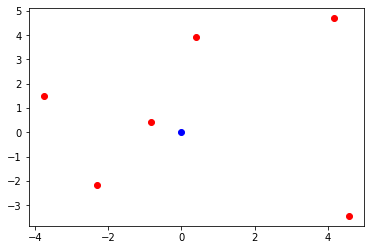

In [26]:
plt.scatter(target_coord[0], target_coord[1], color='blue')
plt.scatter([emp_coord[0] for emp_coord in employee_coords], [emp_coord[1] for emp_coord in employee_coords], color='red')